# Estimating the Date of COVID-19 Changes

https://nbviewer.jupyter.org/github/jramkiss/jramkiss.github.io/blob/master/_posts/notebooks/covid19-changes.ipynb 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# from google.colab import files
# from io import StringIO
# uploaded = files.upload()

url = 'https://raw.githubusercontent.com/assemzh/ProbProg-COVID-19/master/full_grouped.csv'
data = pd.read_csv(url)

data.Date = pd.to_datetime(data.Date)

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Create country


In [ ]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, end_date, state = False) : 
    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

     # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    std_dateparser = lambda x: str(x)[5:10]
    df.date = pd.to_datetime(df.date)
    df['date_only'] = df.date.apply(std_dateparser)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]


    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ax = [ax]
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 ax = ax[0])

    ax[0].set(ylabel='Daily Confirmed Cases')

    ax[0].axvline(pd.to_datetime('2020-04-07'), 
              linestyle = '--', linewidth = 1.5,
              label = "Policy start: Apr 7, 2020" ,
              color = "red") 

    
    ax[0].xaxis.get_label().set_fontsize(22)
    ax[0].yaxis.get_label().set_fontsize(22)
    x = df.date
    # ax[0].set_xticks(x[::30])
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))   #to get a tick every month

    ax[0].title.set_fontsize(20)
    ax[0].tick_params(labelsize=22)
    myFmt = mdates.DateFormatter('%b %-d, %Y')
    ax[0].xaxis.set_major_formatter(myFmt)

    ax[0].set(ylabel='', xlabel='');
    ax[0].legend(loc = "bottom right", fontsize=22)

    sns.set_style("ticks")
    plt.tight_layout()
    sns.despine()
    plt.savefig('/content/sample_data/sing_daily.pdf')
    print(df.tail())
    return df


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

       country       date  confirmed  ...  recovered  date_only daily_confirmed
126  Singapore 2020-05-27      32876  ...      17276      05-27             533
127  Singapore 2020-05-28      33249  ...      18294      05-28             373
128  Singapore 2020-05-29      33860  ...      19631      05-29             611
129  Singapore 2020-05-30      34366  ...      20727      05-30             506
130  Singapore 2020-05-31      34884  ...      21699      05-31             518

[5 rows x 7 columns]


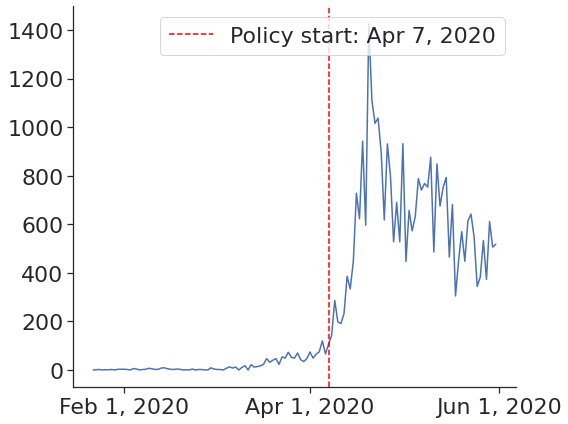

In [ ]:
cad = create_country("Singapore", end_date = "2020-05-31")

In [ ]:
cad_start = "2020-04-01" # 13 confirmed cases
cad = cad[cad.date >= cad_start].reset_index(drop = True)
cad["days_since_start"] = np.arange(cad.shape[0]) + 1

In [ ]:
cad.shape
cad_tmp = cad[cad.date < "2020-05-31"]
cad_tmp.shape

(60, 8)

## Data for Regression

In [ ]:
# variable for data to easily swap it out:
country_ = "Singapore"
reg_data = cad_tmp.copy()

In [ ]:
reg_data.head()

,country,date,confirmed,deaths,recovered,date_only,daily_confirmed,days_since_start
0,Singapore,2020-04-01,1000,3,245,04-01,74,1
1,Singapore,2020-04-02,1049,4,266,04-02,49,2
2,Singapore,2020-04-03,1114,5,282,04-03,65,3
3,Singapore,2020-04-04,1189,6,297,04-04,75,4
4,Singapore,2020-04-05,1309,6,320,04-05,120,5


## Change Point Estimation in Pyro

In [ ]:
!pip install pyro-ppl
!pip install numpyro

In [ ]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [ ]:
# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class COVID_change(PyroModule):
    def __init__(self, in_features, out_features, b1_mu, b2_mu):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear1.weight = PyroSample(dist.Normal(0.5, 0.25).expand([1, 1]).to_event(1))
        self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
        
        # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
        self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear2.weight = PyroSample(dist.Normal(0., 0.25).expand([1, 1])) #.to_event(1))
        self.linear2.bias = PyroSample(dist.Normal(b2_mu, b2_mu/4))

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.Beta(4, 3))
        sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
        # fit lm's to data based on tau
        sep = int(np.ceil(tau.detach().numpy() * len(x)))
        mean1 = self.linear1(x[:sep]).squeeze(-1)
        mean2 = self.linear2(x[sep:]).squeeze(-1)
        mean = torch.cat((mean1, mean2))
        obs = pyro.sample("obs", dist.StudentT(2, mean, sigma), obs=y)
        return mean

In [ ]:
tensor_data = torch.tensor(reg_data[["confirmed", "days_since_start", "daily_confirmed"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])
y_data_daily = np.log(tensor_data[:, 2])
# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.25)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.75)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

Prior mean for Bias 1:  7.4748335
Prior mean for Bias 2:  10.33601


## Approximate Inference with Stochastic Variational Inference

# HMC with NUTS

In [ ]:
model = COVID_change(1, 1, 
                     b1_mu = bias_1_mean,
                     b2_mu = bias_2_mean)
# need more than 400 samples/chain if we want to use a flat prior on b_2 and w_2
num_samples = 400 
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=num_samples,
            warmup_steps = 200,
            num_chains = 1)
mcmc.run(x_data, y_data)
samples = mcmc.get_samples()

Sample: 100%|██████████| 600/600 [24:27,  2.45s/it, step size=1.31e-04, acc. prob=0.936]


In [ ]:
# Save the model:
import dill
# with open('sing.pkl', 'wb') as f:
# 	dill.dump(mcmc, f)
with open('sing.pkl', 'rb') as f:
	mcmc = dill.load(f)
 
samples = mcmc.get_samples()

In [ ]:
# extract individual posteriors
weight_1_post = samples["linear1.weight"].detach().numpy()
weight_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

# build likelihood distribution:
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
mean_ = torch.zeros(len(tau_days), len(x_data))
obs_ = torch.zeros(len(tau_days), len(x_data))
for i in range(len(tau_days)) : 
    mean_[i, :] = torch.cat((x_data[:tau_days[i]] * weight_1_post[i] + bias_1_post[i],
                          x_data[tau_days[i]:] * weight_2_post[i] + bias_2_post[i])).reshape(len(x_data))
    obs_[i, :] = dist.Normal(mean_[i, :], sigma_post[i]).sample()
samples["_RETURN"] = mean_
samples["obs"] = obs_
pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma
y_shift = np.exp(y["mean"]) - np.exp(torch.cat((y["mean"][0:1], y["mean"][:-1])))
print(y_shift)
predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_confirmed": y_data,
    "true_daily_confirmed": y_data_daily,
    "y_daily_mean": y_shift
})

w1_ = pred_summary["linear1.weight"]
w2_ = pred_summary["linear2.weight"]

b1_ = pred_summary["linear1.bias"]
b2_ = pred_summary["linear2.bias"]

tau_ = pred_summary["tau"]
sigma_ = pred_summary["sigma"]

ind = int(np.ceil(tau_["mean"] * len(x_data)))

tensor([   0.0000,   91.0333,  117.2389,  111.3232,  132.6851,  154.1053,
         176.6852,  189.5868,  219.5638,  252.1475,  283.0125,  303.7195,
         357.8264,  395.5989,  447.8628,  528.4072,  594.4321,  641.3208,
         742.0659,  807.9922,  958.1919, 1067.6152, 1184.2754, 1413.8848,
        1539.2334, 1647.6934,  846.7627,  343.4326,  442.3613,  434.3516,
         469.3164,  466.8262,  464.2715,  548.7402,  389.9570,  517.7715,
         599.3203,  608.7676,  428.4219,  556.6855,  609.4785,  663.9512,
         555.2676,  791.9492,  698.9551,  444.7305,  645.4590,  683.9355,
         779.8301,  730.1484,  674.6992,  931.6797,  799.6855,  783.1582,
         930.9648,  828.2617,  765.9258,  992.9492,  900.7305, 1058.3867])


## Model Diagnostics

- Residual plots: Should these be samples from the likelihood compared with the actual data? Or just the mean of the likelihood?
- $\hat{R}$: The factor that the scale of the current distribution will be reduced by if we were to run the simulations forever. As n tends to $\inf$, $\hat{R}$ tends to 1. So we want values close to 1.
- Mixing and Stationarity: I sampled 4 chains. Do I then take these chains, split them in half and plot them. If they converge to the same stationary distribution, does that mean the MCMC converged? What do I do with more sampled chains?

In [ ]:
mcmc.summary()
diag = mcmc.diagnostics()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                tau      0.42      0.02      0.42      0.40      0.45     34.82      1.13
              sigma      0.05      0.01      0.05      0.04      0.07     20.31      1.04
linear1.weight[0,0]      0.12      0.00      0.12      0.12      0.13     16.22      1.00
       linear1.bias      6.47      0.04      6.47      6.40      6.54     15.20      1.00
linear2.weight[0,0]      0.03      0.00      0.03      0.02      0.03    105.41      1.03
       linear2.bias      8.97      0.06      8.96      8.86      9.06     96.12      1.03

Number of divergences: 0


## Posterior Plots

26
2020-04-27 00:00:00


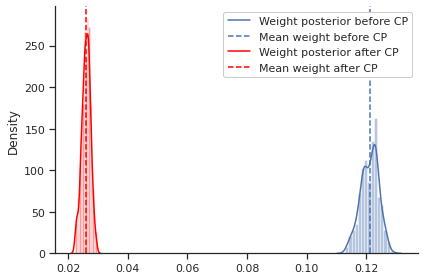

In [ ]:
print(ind)
print(reg_data.date[ind])

sns.distplot(weight_1_post, 
             kde_kws = {"label": "Weight posterior before CP"}, 
             norm_hist = True,
             kde = True)
plt.axvline(x = w1_["mean"], linestyle = '--',label = "Mean weight before CP" ,)

sns.distplot(weight_2_post, 
             kde_kws = {"label": "Weight posterior after CP"}, 
             color = "red",
             norm_hist = True,
             kde = True)
plt.axvline(x = w2_["mean"], linestyle = '--',label = "Mean weight after CP" ,
              color = "red")

legend = plt.legend(loc='upper right')
legend.get_frame().set_alpha(1)
sns.set_style("ticks")
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/sing_weights.pdf')

In [ ]:
print(w1_["mean"])
print(w2_["mean"])

tensor([[0.1212]])
tensor([[0.0261]])


In [ ]:
1- w2_['mean']/w1_['mean']

tensor([[0.7850]])

In [ ]:
reg_data[reg_data.date== '2020-05-25']

,country,date,confirmed,deaths,recovered,date_only,daily_confirmed,days_since_start
54,Singapore,2020-05-25,31960,23,15738,05-25,344,55


Date of change for Singapore: 2020-04-27
Index(['country', 'date', 'confirmed', 'deaths', 'recovered', 'date_only',
       'daily_confirmed', 'days_since_start'],
      dtype='object')


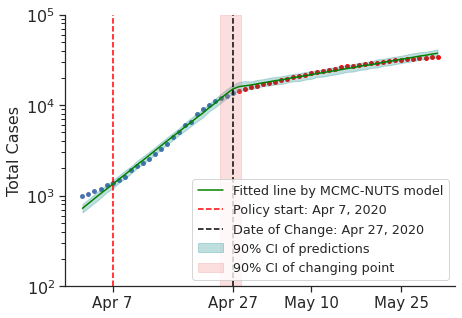

In [ ]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
print("Date of change for {}: {}".format(country_, change_date_))
import seaborn as sns

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax = [ax]
# log regression model
ax[0].scatter(y = np.exp(y_data[:ind]), x = x_data[:ind], s = 15);
ax[0].scatter(y = np.exp(y_data[ind:]), x = x_data[ind:], s = 15, color = "red");

ax[0].plot(predictions["days_since_start"],
           np.exp(predictions["y_mean"]), 
           color = "green",
           label = "Fitted line by MCMC-NUTS model") 
ax[0].axvline(6, 
              linestyle = '--', linewidth = 1.5,
              label = "Policy start: Apr 7, 2020" ,
              color = "red")

ax[0].axvline(ind, 
              linestyle = '--', linewidth = 1.5,
              label = "Date of Change: Apr 27, 2020",
              color = "black")

ax[0].fill_between(predictions["days_since_start"], 
                   np.exp(predictions["y_perc_5"]), 
                   np.exp(predictions["y_perc_95"]), 
                   alpha = 0.25,
                   label = "90% CI of predictions",
                   color = "teal");
ax[0].fill_betweenx([0, 1], 
                    tau_["5%"] * len(x_data), 
                    tau_["95%"] * len(x_data), 
                    alpha = 0.25,
                    label = "90% CI of changing point",
                    color = "lightcoral",
                    transform=ax[0].get_xaxis_transform());
ax[0].set(ylabel = "Total Cases",)

ax[0].legend(loc = "lower right", fontsize=12.8)
ax[0].set_ylim([100,100000])
# ax[0].set_xlim([5,60])
ax[0].xaxis.get_label().set_fontsize(16)
ax[0].yaxis.get_label().set_fontsize(16)
ax[0].title.set_fontsize(20)
ax[0].tick_params(labelsize=16)

plt.xticks(ticks=[6,26,39,54], labels=["Apr 7",
                                             "Apr 27",
                                             "May 10",
                                            "May 25"], fontsize=15)
ax[0].set_yscale('log')
plt.setp(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
print(reg_data.columns)
myFmt = mdates.DateFormatter('%m-%d')
sns.set_style("ticks")
sns.despine()
plt.savefig('/content/sample_data/sing_cp.pdf')
